# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 기압(3개) : 'month', 'weekday', '시간'
    * 기온(5개) : 'month', 'weekday', '시간', '습도', '기압'
    * 공급량 예측(6개) : 'month', 'weekday', '시간', '구분', '기온', '기압'
    * PCA 적용
* 공급량 log적용
* 2개 모델('lightgbm', 'catboost') 예측 평균

In [ ]:
# 제출 파일명 : sub19_pycaret07.csv
# 제출 점수 : 

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [1]:
# colab에서 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치후 런타임 재시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 9s (1,127 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [2]:
# 설치 후 런타임 재시작
!pip install pycaret

     |████████████████████████████████| 288 kB 5.4 MB/s 
     |████████████████████████████████| 1.7 MB 36.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 33.6 MB/s 
     |████████████████████████████████| 261 kB 48.3 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 113 kB 46.1 MB/s 
     |████████████████████████████████| 6.8 MB 31.9 MB/s 
     |████████████████████████████████| 2.0 MB 34.9 MB/s 
     |████████████████████████████████| 16.9 MB 42 kB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 167 kB 44.0 MB/s 
     |████████████████████████████████| 10.1 MB 35.4 MB/s 
     |████████████████████████████████| 596 kB 35.4 MB/s 
     |████████████████████████████████| 303 kB 28.2 MB/s 
     |██████████████████

In [4]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 27 kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 구글 드라이브에서 파일이 있는 폴더로 이동
%cd /content/drive/MyDrive/GitHub/LikeLion_13th_DataCourse/TP02

/content/drive/MyDrive/GitHub/LikeLion_13th_DataCourse/TP02


In [5]:
import catboost

In [6]:
import time
import datetime
import pandas as pd

### 2013-2018년 가스공급량과 기온 자료

In [7]:
total = pd.read_csv('2013-2018년_가스공급량_기온_습도_기압01.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


### 2019년 데이터

In [8]:
test2019 = pd.read_csv('./data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [9]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [10]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [11]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


### 상관계수 확인

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

import platform
from matplotlib import font_manager, rc

# path = "C:/Windows/Fonts/malgun.ttf"
# if platform.system() == "Windows":
#     font_name = font_manager.FontProperties(fname=path).get_name()
#     rc('font', family=font_name)
# elif platform.system()=="Darwin":
#     rc('font', family='AppleGothic')
# else:
#     print("Unknown System")

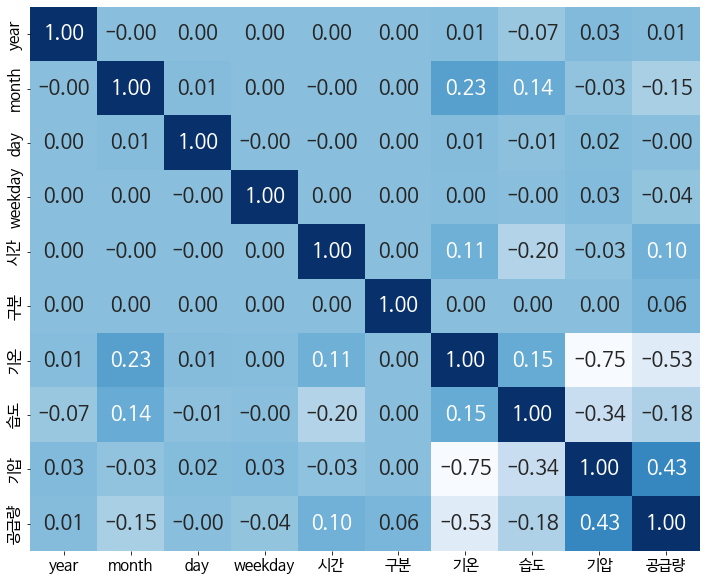

In [13]:
plt.figure(figsize=(12,10))
plt.rc('font', family='NanumBarunGothic')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(total[['year','month', 'day', 'weekday', '시간', '구분', '기온','습도','기압','공급량']].corr(), cmap='Blues', annot=True, fmt='.2f', cbar=False, annot_kws={"size": 20})

(array([ 1631., 12285., 32193., 47222., 53382., 56679., 58002., 46487.,
        38262., 21945.]),
 array([  7. ,  16.3,  25.6,  34.9,  44.2,  53.5,  62.8,  72.1,  81.4,
         90.7, 100. ]),
 <a list of 10 Patch objects>)

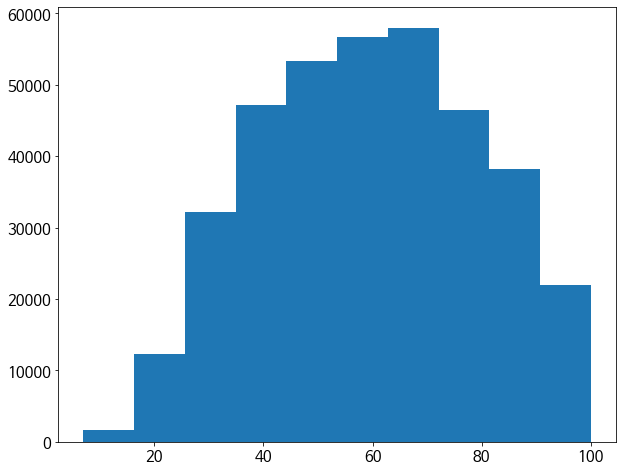

In [14]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='습도', data=total)

(array([  420.,  1414.,  9597., 43568., 77329., 70378., 79037., 60480.,
        23170.,  2695.]),
 array([ 976.5 ,  981.68,  986.86,  992.04,  997.22, 1002.4 , 1007.58,
        1012.76, 1017.94, 1023.12, 1028.3 ]),
 <a list of 10 Patch objects>)

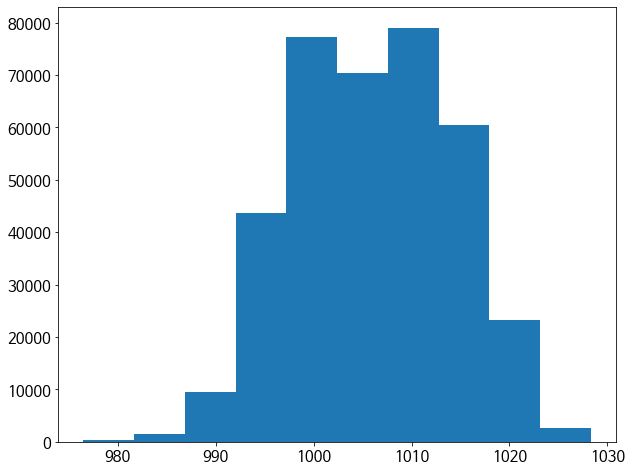

In [15]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기압', data=total)

(array([ 1708., 12180., 36729., 52906., 48832., 49889., 64701., 73080.,
        26040.,  2023.]),
 array([-18.  , -12.26,  -6.52,  -0.78,   4.96,  10.7 ,  16.44,  22.18,
         27.92,  33.66,  39.4 ]),
 <a list of 10 Patch objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


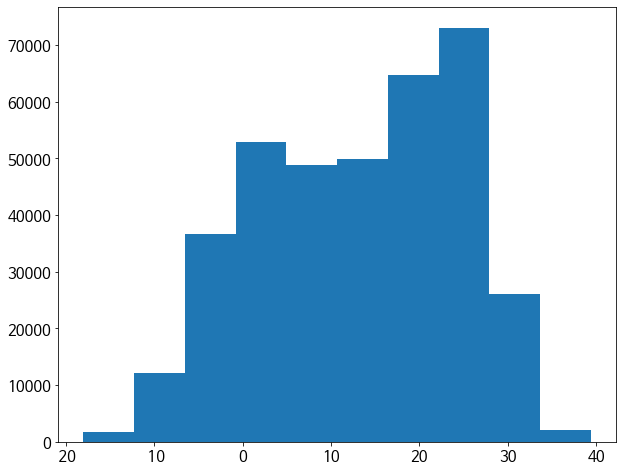

In [16]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기온', data=total)

(array([2.56069e+05, 7.60110e+04, 2.76280e+04, 7.43600e+03, 8.86000e+02,
        5.30000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.37800000e+00, 1.16060190e+03, 2.31982580e+03, 3.47904970e+03,
        4.63827360e+03, 5.79749750e+03, 6.95672140e+03, 8.11594530e+03,
        9.27516920e+03, 1.04343931e+04, 1.15936170e+04]),
 <a list of 10 Patch objects>)

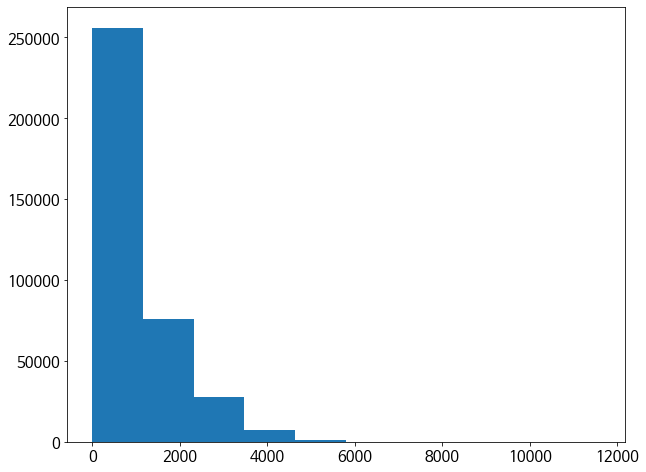

In [17]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량', data=total)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 864x576 with 0 Axes>

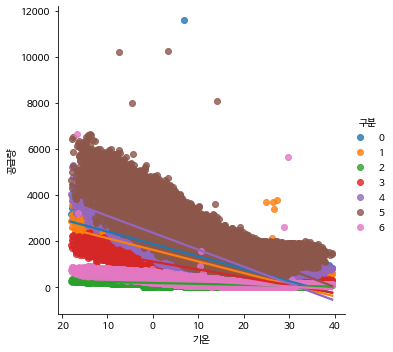

In [18]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

# 2019년 기온 예측하기
* 기압 예측

In [19]:
from pycaret.regression import *

## 기압 예측

In [20]:
# 학습 특성 : 'month', 'weekday', '시간'
# 타겟 특성 : '기압'

exp = setup(total, target='기압', ignore_features=['공급량', 'year', 'day', '기온', '습도', '구분'], 
            use_gpu=True)

,Description,Value
0,session_id,5695
1,Target,기압
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 20)"


In [21]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [22]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.6726,22.3893,4.7317,0.6589,0.0047,0.0037
1,3.6889,22.3938,4.7322,0.6546,0.0047,0.0037
2,3.6592,22.4194,4.7349,0.6540,0.0047,0.0036
3,3.6543,22.2266,4.7145,0.6588,0.0047,0.0036
4,3.6887,22.5932,4.7532,0.6551,0.0047,0.0037
5,3.6454,22.2286,4.7147,0.6582,0.0047,0.0036
6,3.6547,22.2098,4.7127,0.6580,0.0047,0.0036
7,3.6785,22.4682,4.7401,0.6560,0.0047,0.0037
8,3.7009,22.7109,4.7656,0.6544,0.0047,0.0037
9,3.6197,21.7791,4.6668,0.6596,0.0046,0.0036


0:00:14


In [23]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.6725,22.3864,4.7314,0.6589,0.0047,0.0037
1,3.6911,22.4144,4.7344,0.6543,0.0047,0.0037
2,3.6612,22.4287,4.7359,0.6538,0.0047,0.0036
3,3.6544,22.2324,4.7151,0.6587,0.0047,0.0036
4,3.6914,22.6090,4.7549,0.6548,0.0047,0.0037
5,3.6466,22.2375,4.7157,0.6581,0.0047,0.0036
6,3.6556,22.2145,4.7132,0.6579,0.0047,0.0036
7,3.6789,22.4720,4.7405,0.6559,0.0047,0.0037
8,3.7024,22.7312,4.7677,0.6540,0.0047,0.0037
9,3.6209,21.7943,4.6684,0.6594,0.0046,0.0036


0:01:47


In [24]:
# lightgbm 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.6729,22.3858,4.7314,0.6589,0.0047,0.0037
1,3.6893,22.3916,4.7320,0.6546,0.0047,0.0037
2,3.6588,22.4108,4.7340,0.6541,0.0047,0.0036
3,3.6544,22.2268,4.7145,0.6588,0.0047,0.0036
4,3.6891,22.5910,4.7530,0.6551,0.0047,0.0037
5,3.6458,22.2361,4.7155,0.6581,0.0047,0.0036
6,3.6539,22.1971,4.7114,0.6582,0.0047,0.0036
7,3.6781,22.4647,4.7397,0.6560,0.0047,0.0037
8,3.7010,22.7226,4.7668,0.6542,0.0047,0.0037
9,3.6190,21.7747,4.6663,0.6597,0.0046,0.0036


0:05:17


In [25]:
# cat 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.6698,22.3535,4.7279,0.6594,0.0047,0.0036
1,3.6879,22.3760,4.7303,0.6549,0.0047,0.0037
2,3.6572,22.3921,4.7320,0.6544,0.0047,0.0036
3,3.6527,22.2071,4.7124,0.6591,0.0047,0.0036
4,3.6871,22.5692,4.7507,0.6554,0.0047,0.0037
5,3.6429,22.2038,4.7121,0.6586,0.0047,0.0036
6,3.6516,22.1729,4.7088,0.6586,0.0047,0.0036
7,3.6773,22.4504,4.7382,0.6563,0.0047,0.0037
8,3.6988,22.6944,4.7639,0.6546,0.0047,0.0037
9,3.6172,21.7532,4.6640,0.6600,0.0046,0.0036


0:04:15


In [26]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 

In [27]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:35


### 2019년 기압 예측

In [28]:
# lgbm 모델 기압 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
pressure2019_pred_lgbm = predict_model(pressure_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [29]:
# cat 모델 기압 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
pressure2019_pred_cat = predict_model(pressure_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [30]:
pressure2019_pred_lgbm.head()

,month,weekday,시간,Label
0,1,1,01,1014.128589
1,1,1,02,1014.151988
2,1,1,03,1014.200245
3,1,1,04,1014.100020
4,1,1,05,1014.093076


In [31]:
pressure2019_pred_cat.head()

,month,weekday,시간,Label
0,1,1,01,1014.040694
1,1,1,02,1014.029946
2,1,1,03,1014.000273
3,1,1,04,1013.959420
4,1,1,05,1014.051550


In [32]:
# 두 모델 기압 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

In [33]:
pressure2019_pred.head()

0    1014.084642
1    1014.090967
2    1014.100259
3    1014.029720
4    1014.072313
Name: Label, dtype: float64

In [34]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [35]:
# 2019년 예측 기압 열 추가
test2019['기압'] = pressure2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,1014.084642
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,1014.090967
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,1014.100259
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,1014.029720
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,1014.072313


## 기온예측

In [36]:
# 학습 특성 : 'month', 'weekday', '시간', '기압'
# 타겟 특성 : '기온'

exp = setup(total, target='기온', ignore_features=['공급량', 'year', 'day', '구분', '습도'],
            use_gpu=True)

,Description,Value
0,session_id,7098
1,Target,기온
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 21)"


In [37]:
# 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [38]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.6909,12.0063,3.4650,0.9061,0.4757,0.6927
1,2.7024,12.0540,3.4719,0.9058,0.4815,0.7177
2,2.7229,12.2676,3.5025,0.9033,0.4867,0.7599
3,2.7105,12.1258,3.4822,0.9050,0.4793,0.7457
4,2.7094,12.1120,3.4802,0.9037,0.4913,0.7512
5,2.7194,12.1793,3.4899,0.9045,0.4881,0.7314
6,2.7353,12.3695,3.5170,0.9020,0.4868,0.7460
7,2.7161,12.1487,3.4855,0.9045,0.4838,0.7477
8,2.7205,12.2730,3.5033,0.9029,0.4812,0.7503
9,2.7025,12.0521,3.4716,0.9046,0.4825,0.7279


0:00:15


In [39]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.5754,10.9793,3.3135,0.9141,0.4562,0.6716
1,2.5878,11.0778,3.3283,0.9135,0.4607,0.6876
2,2.5949,11.1643,3.3413,0.9120,0.4669,0.7229
3,2.5973,11.1201,3.3347,0.9128,0.4652,0.7194
4,2.5824,11.0304,3.3212,0.9123,0.4685,0.7196
5,2.5907,11.0634,3.3262,0.9133,0.4627,0.7028
6,2.6060,11.2799,3.3586,0.9106,0.4652,0.7043
7,2.5959,11.1326,3.3366,0.9125,0.4605,0.7106
8,2.5956,11.1889,3.3450,0.9115,0.4641,0.7096
9,2.5916,11.0934,3.3307,0.9122,0.4645,0.7019


0:01:46


In [40]:
# lgbm 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.4750,10.1538,3.1865,0.9206,0.4412,0.6476
1,2.4866,10.3061,3.2103,0.9195,0.4474,0.6608
2,2.5012,10.4232,3.2285,0.9178,0.4500,0.6909
3,2.4982,10.3820,3.2221,0.9186,0.4527,0.6977
4,2.4906,10.2902,3.2078,0.9182,0.4538,0.7040
5,2.4968,10.3554,3.2180,0.9188,0.4550,0.6648
6,2.5107,10.4955,3.2397,0.9168,0.4545,0.6721
7,2.5025,10.3920,3.2237,0.9183,0.4463,0.6763
8,2.5042,10.4954,3.2397,0.9170,0.4505,0.6813
9,2.5076,10.4084,3.2262,0.9176,0.4534,0.6795


0:07:31


In [41]:
# cat 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.5705,10.9297,3.3060,0.9145,0.4534,0.6718
1,2.5769,11.0001,3.3166,0.9141,0.4589,0.6853
2,2.5894,11.1229,3.3351,0.9123,0.4663,0.7244
3,2.5912,11.0735,3.3277,0.9132,0.4640,0.7191
4,2.5712,10.9375,3.3072,0.9131,0.4693,0.7208
5,2.5857,11.0273,3.3207,0.9135,0.4641,0.7036
6,2.5991,11.2300,3.3511,0.9110,0.4659,0.7070
7,2.5918,11.0813,3.3289,0.9129,0.4597,0.7081
8,2.5880,11.1279,3.3358,0.9120,0.4631,0.7137
9,2.5829,11.0100,3.3181,0.9129,0.4617,0.6985


0:04:34


In [42]:
# lgbm 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

In [43]:
# cat 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:43


### 2019년 기온 예측

In [44]:
# lgbm 기온 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '기압']]
temp2019_pred_lgbm = predict_model(temp_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [45]:
# cat 기온 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '기압']]
temp2019_pred_cat = predict_model(temp_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [46]:
temp2019_pred_lgbm.head()

,month,weekday,시간,기압,Label
0,1,1,01,1014.084642,-3.156796
1,1,1,02,1014.090967,-3.444153
2,1,1,03,1014.100259,-3.212576
3,1,1,04,1014.029720,-4.962371
4,1,1,05,1014.072313,-3.564995


In [47]:
temp2019_pred_cat.head()

,month,weekday,시간,기압,Label
0,1,1,01,1014.084642,-4.655577
1,1,1,02,1014.090967,-4.866858
2,1,1,03,1014.100259,-5.259276
3,1,1,04,1014.029720,-5.537694
4,1,1,05,1014.072313,-5.826060


In [48]:
# 두 모델 기온 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

In [49]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,1014.084642
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,1014.090967
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,1014.100259
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,1014.029720
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,1014.072313


In [50]:
# 2019년 예측 기온 열 추가
test2019['기온'] = temp2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기압,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,1014.084642,-3.906186
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,1014.090967,-4.155505
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,1014.100259,-4.235926
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,1014.029720,-5.250033
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,1014.072313,-4.695528


# 2019년 가스 공급량 예측

In [51]:
import numpy as np

In [52]:
total['log_공급량'] = np.log1p(total['공급량'])
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,log_공급량
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,7.823297
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,7.682525
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0,5.425734
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0,7.269280
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0,8.093718


In [53]:
# 학습 특성 : 'month', 'weekday', '시간', '구분', '기압', '기온'
exp = setup(total, target='log_공급량', ignore_features=['year', '공급량', 'day', '습도'],
            use_gpu=True)

,Description,Value
0,session_id,3947
1,Target,log_공급량
2,Original Data,"(368088, 11)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 29)"


In [54]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1293,0.0929,0.3048,0.9356,0.0831,0.0414
1,0.1265,0.0884,0.2973,0.9380,0.0813,0.0402
2,0.1283,0.0959,0.3096,0.9337,0.0851,0.0423
3,0.1260,0.0864,0.2940,0.9383,0.0804,0.0397
4,0.1284,0.0928,0.3047,0.9363,0.0842,0.0421
5,0.1266,0.0895,0.2992,0.9368,0.0823,0.0408
6,0.1288,0.0947,0.3078,0.9341,0.0853,0.0427
7,0.1319,0.1045,0.3232,0.9294,0.0899,0.0456
8,0.1274,0.0859,0.2931,0.9390,0.0800,0.0398
9,0.1275,0.0877,0.2962,0.9378,0.0803,0.0398


0:00:19


In [55]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1201,0.0841,0.2900,0.9417,0.0792,0.0381
1,0.1184,0.0807,0.2841,0.9434,0.0778,0.0372
2,0.1199,0.0869,0.2948,0.9399,0.0814,0.0393
3,0.1166,0.0767,0.2769,0.9453,0.0761,0.0364
4,0.1198,0.0834,0.2888,0.9428,0.0799,0.0387
5,0.1169,0.0798,0.2825,0.9437,0.0783,0.0375
6,0.1204,0.0853,0.2920,0.9407,0.0815,0.0396
7,0.1225,0.0942,0.3070,0.9363,0.0858,0.0420
8,0.1190,0.0781,0.2795,0.9445,0.0761,0.0365
9,0.1182,0.0793,0.2815,0.9438,0.0767,0.0367


0:01:47


In [56]:
# lgbm 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1276,0.0954,0.3089,0.9338,0.0840,0.0414
1,0.1259,0.0935,0.3057,0.9345,0.0835,0.0409
2,0.1273,0.0984,0.3136,0.9320,0.0859,0.0424
3,0.1245,0.0899,0.2999,0.9358,0.0816,0.0399
4,0.1280,0.0983,0.3135,0.9326,0.0862,0.0427
5,0.1245,0.0925,0.3041,0.9347,0.0836,0.0409
6,0.1280,0.0975,0.3122,0.9322,0.0863,0.0428
7,0.1304,0.1075,0.3279,0.9274,0.0910,0.0458
8,0.1262,0.0893,0.2988,0.9365,0.0813,0.0400
9,0.1257,0.0896,0.2993,0.9365,0.0812,0.0398


0:05:44


In [57]:
# cat 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1230,0.0863,0.2938,0.9402,0.0798,0.0387
1,0.1198,0.0811,0.2848,0.9431,0.0776,0.0373
2,0.1223,0.0876,0.2960,0.9394,0.0814,0.0396
3,0.1181,0.0785,0.2801,0.9440,0.0766,0.0367
4,0.1214,0.0846,0.2908,0.9420,0.0803,0.0390
5,0.1187,0.0805,0.2837,0.9432,0.0782,0.0376
6,0.1219,0.0866,0.2943,0.9398,0.0819,0.0399
7,0.1239,0.0943,0.3071,0.9363,0.0855,0.0420
8,0.1210,0.0793,0.2816,0.9436,0.0763,0.0369
9,0.1208,0.0807,0.2841,0.9428,0.0771,0.0371


0:04:01


In [58]:
# lgbm 훈련 완료
start = time.time()

gas_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

In [59]:
# cat 훈련 완료
start = time.time()

gas_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:35


In [60]:
# lgbm log_공급량 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '구분', '기압', '기온']]
log_gas2019_pred_lgbm = predict_model(gas_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [61]:
# cat log_공급량 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '구분', '기압', '기온']]
log_gas2019_pred_cat = predict_model(gas_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [62]:
log_gas2019_pred_lgbm.head()

,month,weekday,시간,구분,기압,기온,Label
0,1,1,01,0,1014.084642,-3.906186,7.596670
1,1,1,02,0,1014.090967,-4.155505,7.462192
2,1,1,03,0,1014.100259,-4.235926,7.404011
3,1,1,04,0,1014.029720,-5.250033,7.462115
4,1,1,05,0,1014.072313,-4.695528,7.519066


In [63]:
log_gas2019_pred_cat.head()

,month,weekday,시간,구분,기압,기온,Label
0,1,1,01,0,1014.084642,-3.906186,7.613824
1,1,1,02,0,1014.090967,-4.155505,7.491553
2,1,1,03,0,1014.100259,-4.235926,7.422608
3,1,1,04,0,1014.029720,-5.250033,7.535312
4,1,1,05,0,1014.072313,-4.695528,7.632506


In [64]:
# lgbm log_공급량 값을 공급량 값으로 변환
gas_pred2019_lgbm = np.expm1(log_gas2019_pred_lgbm['Label'])
gas_pred2019_lgbm.head()

0    1990.553257
1    1739.960783
2    1641.560001
3    1739.825248
4    1841.845260
Name: Label, dtype: float64

In [65]:
# cat log_공급량 값을 공급량 값으로 변환
gas_pred2019_cat = np.expm1(log_gas2019_pred_cat['Label'])
gas_pred2019_cat.head()

0    2025.010208
1    1791.834302
2    1672.391319
3    1872.028792
4    2063.216205
Name: Label, dtype: float64

In [66]:
# 두 모델 공급량 예측 평균
gas2019_pred = (gas_pred2019_lgbm + gas_pred2019_cat) / 2
gas2019_pred.head()

0    2007.781733
1    1765.897543
2    1656.975660
3    1805.927020
4    1952.530733
Name: Label, dtype: float64

# 제출 파일 만들기

In [67]:
sub = pd.read_csv('./data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [68]:
sub['공급량'] = gas2019_pred
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2007.781733
1,2019-01-01 02 A,1765.897543
2,2019-01-01 03 A,1656.975660
3,2019-01-01 04 A,1805.927020
4,2019-01-01 05 A,1952.530733


In [69]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [70]:
sub.to_csv("sub19_pycaret07.csv", index=False)